# **1. Import necessary libraries & Data Loading**



In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')


print("Loading Adult Income dataset...")

# Define column names
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country', 'income'
]

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                header=None, names=column_names)

df['income'] = df['income'].apply(lambda x: 1 if '>50K' in str(x) else 0)

# Basic dataset info
print("\nDataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Class distribution
print("\nClass distribution:")
print(df['income'].value_counts())
print(f"Percentage of high income: {100 * df['income'].mean():.2f}%")

# Identify numerical and categorical columns
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation',
                    'relationship', 'race', 'sex', 'native_country']
numerical_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain',
                  'capital_loss', 'hours_per_week']

print("\nNumerical features:", len(numerical_cols))
print("Numerical features:", numerical_cols)

print("\nCategorical features:", len(categorical_cols))
print("Categorical features:", categorical_cols)

# Check for missing values ('?' is often used in this dataset)
print("\nChecking for missing values ('?'):")
for col in categorical_cols:
    missing = (df[col] == ' ?').sum()
    if missing > 0:
        print(f"{col}: {missing}")

# Replace missing values
for col in categorical_cols:
    df[col] = df[col].replace(' ?', df[col].mode()[0])

Loading Adult Income dataset...

Dataset shape: (32561, 15)

First 5 rows:
   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  in

# **2. Data Visualization**

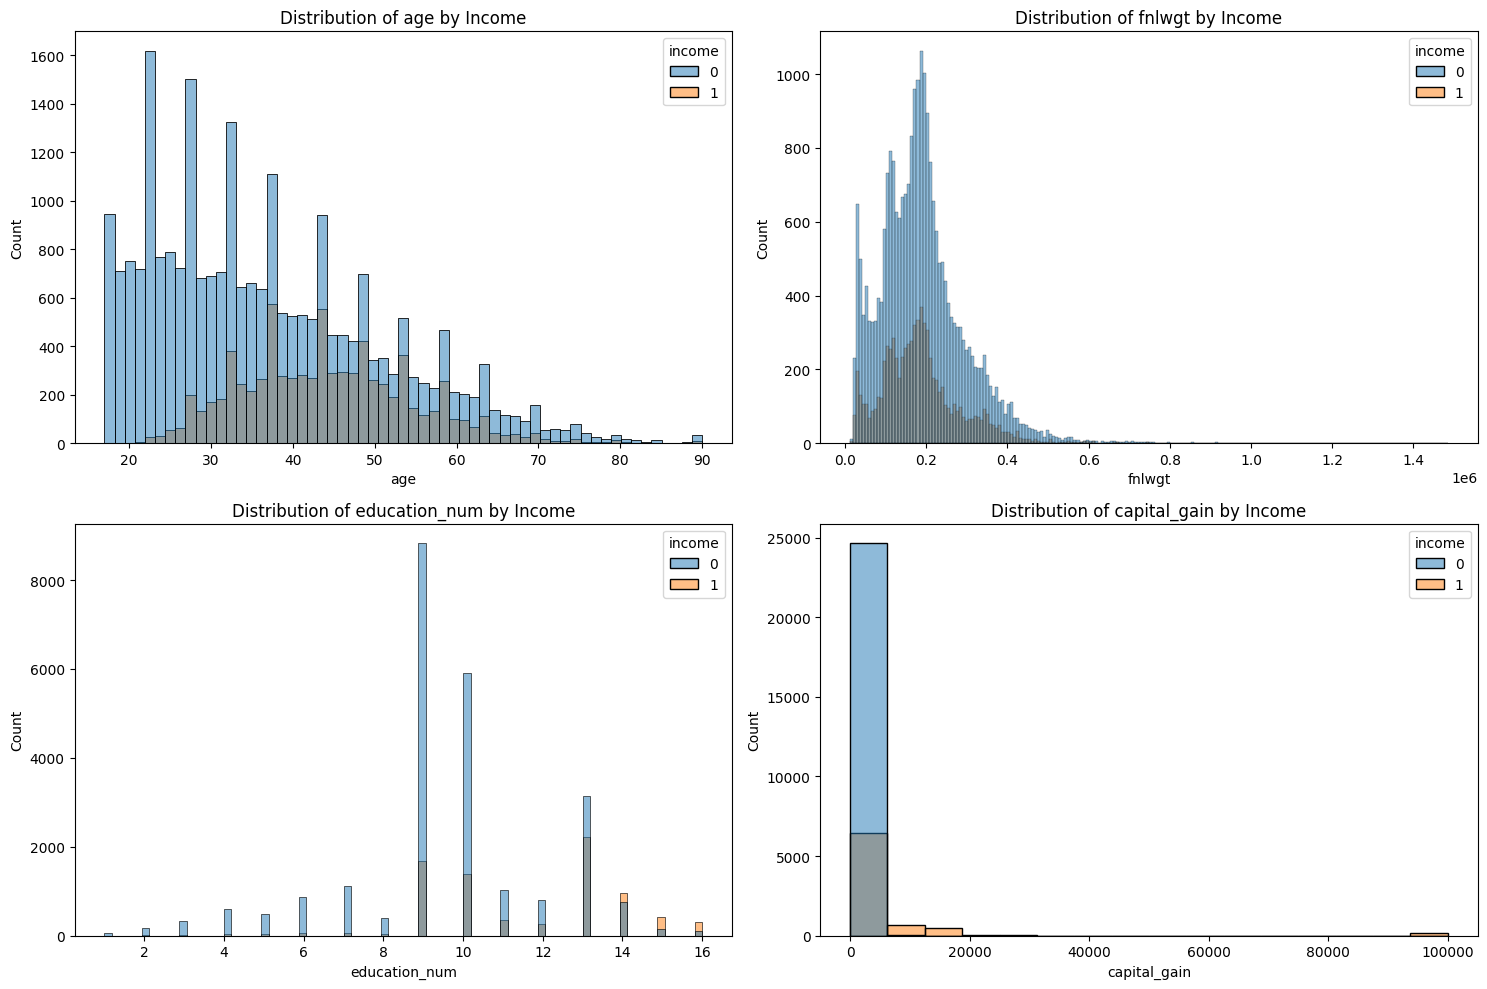

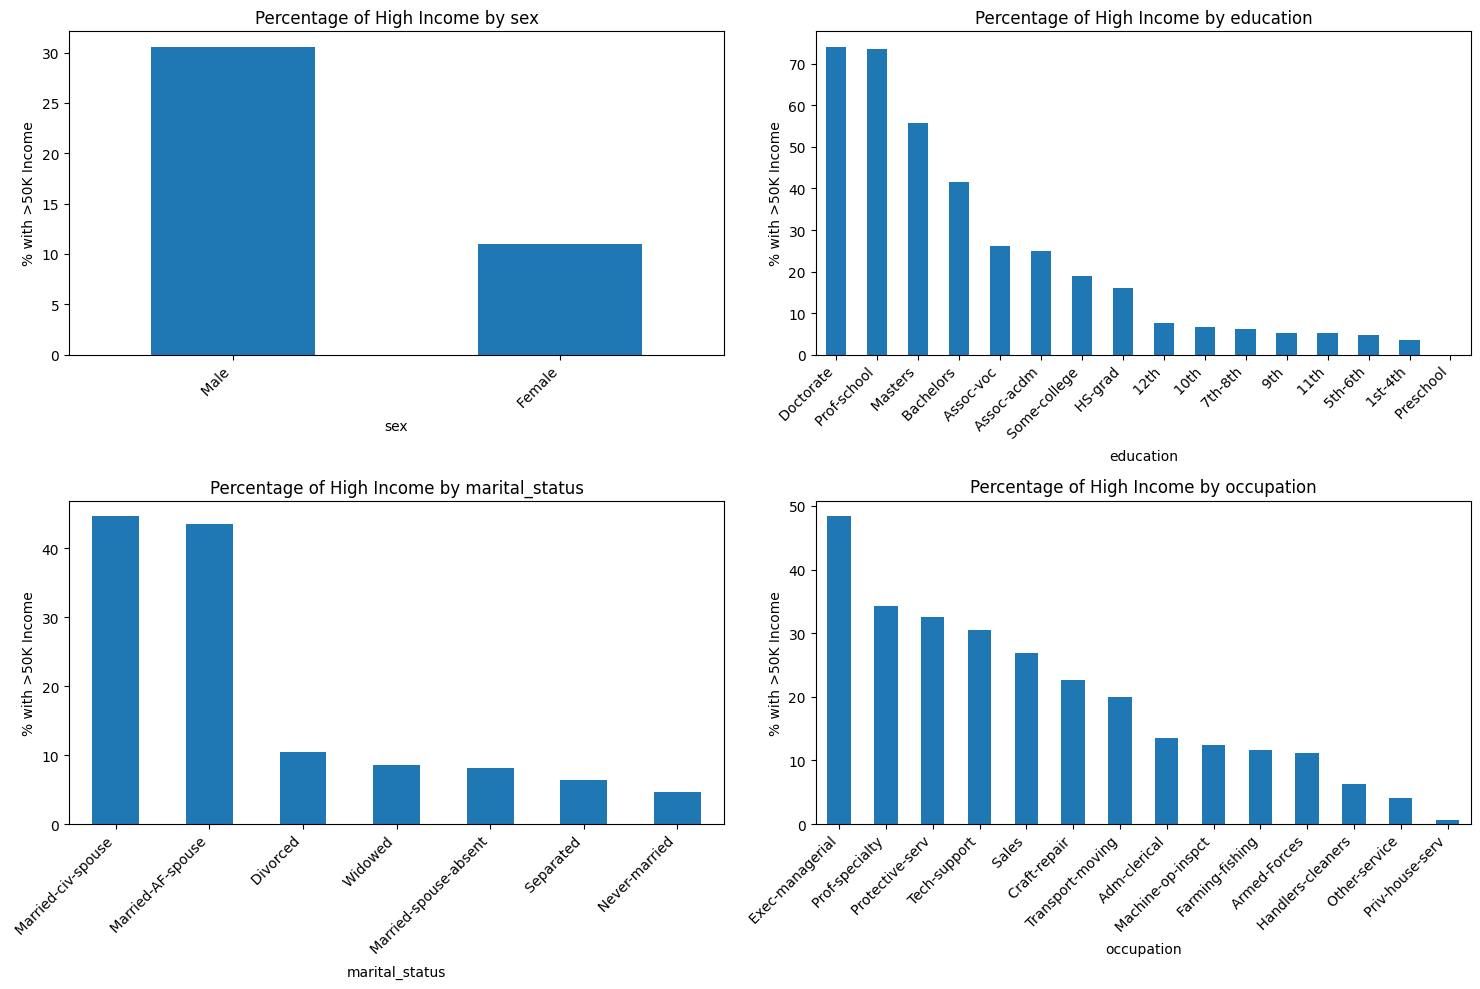

In [ ]:

# Numerical feature distributions
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols[:4]):  # Show first 4 numerical features
    plt.subplot(2, 2, i+1)
    sns.histplot(x=df[col], hue=df['income'])
    plt.title(f'Distribution of {col} by Income')

plt.tight_layout()
plt.show()

# Categorical feature distributions
plt.figure(figsize=(15, 10))

for i, col in enumerate(['sex', 'education', 'marital_status', 'occupation']):
    if i < 4:  # Limit to 4 plots
        plt.subplot(2, 2, i+1)

        # Calculate percentages of high income by category
        category_income = df.groupby(col)['income'].mean() * 100
        category_income.sort_values(ascending=False).plot(kind='bar')

        plt.title(f'Percentage of High Income by {col}')
        plt.ylabel('% with >50K Income')
        plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 3. Model Training


Class distribution in splits:
Train set: [19775  6273]
Test set: [4945 1568]

Training model...

Model Performance:
Accuracy: 0.8575

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4945
           1       0.74      0.64      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.78      0.80      6513
weighted avg       0.85      0.86      0.85      6513



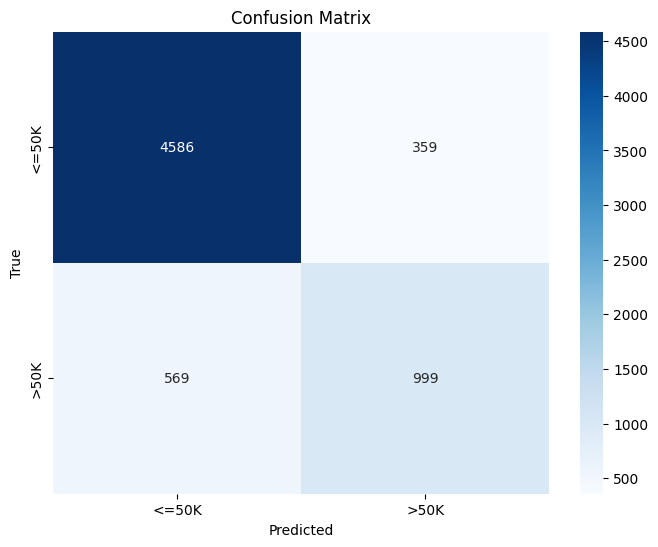

In [ ]:
## 3. Model Training

# Split the data
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify class distribution in splits
print("\nClass distribution in splits:")
print("Train set:", np.bincount(y_train))
print("Test set:", np.bincount(y_test))

# Create preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Create and train model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

print("\nTraining model...")
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=['<=50K', '>50K'],
           yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 4. Feature Importance

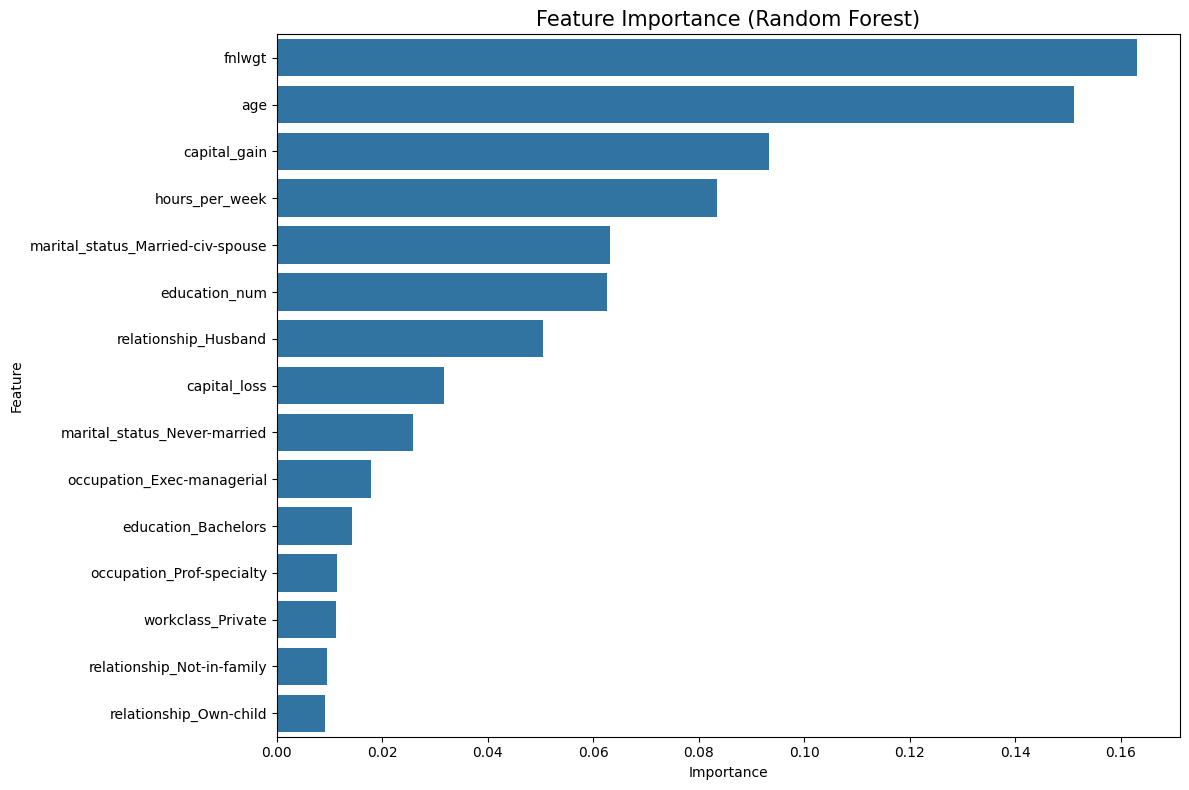


Top 10 most important features:
                              Feature  Importance
1                              fnlwgt    0.163055
0                                 age    0.151064
3                        capital_gain    0.093213
5                      hours_per_week    0.083402
32  marital_status_Married-civ-spouse    0.063187
2                       education_num    0.062670
51               relationship_Husband    0.050494
4                        capital_loss    0.031644
34       marital_status_Never-married    0.025806
40         occupation_Exec-managerial    0.017879


In [ ]:
# Extract feature importances
rf_model = model.named_steps['classifier']
importances = rf_model.feature_importances_

# Get one-hot encoded feature names
enc = model.named_steps['preprocessor'].transformers_[1][1]
feature_names = []

# Add numerical feature names
for col in numerical_cols:
    feature_names.append(col)

# Add categorical feature names with their encoded values
for i, col in enumerate(categorical_cols):
    cats = enc.categories_[i]
    for cat in cats:
        feature_names.append(f"{col}_{cat.strip()}")

# Trim feature_names to match importances length if needed
feature_names = feature_names[:len(importances)]

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort and display top features
top_features = feature_importance.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Feature Importance (Random Forest)', fontsize=15)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(top_features.head(10))


# 5. Permutation Importance


Calculating permutation importance...


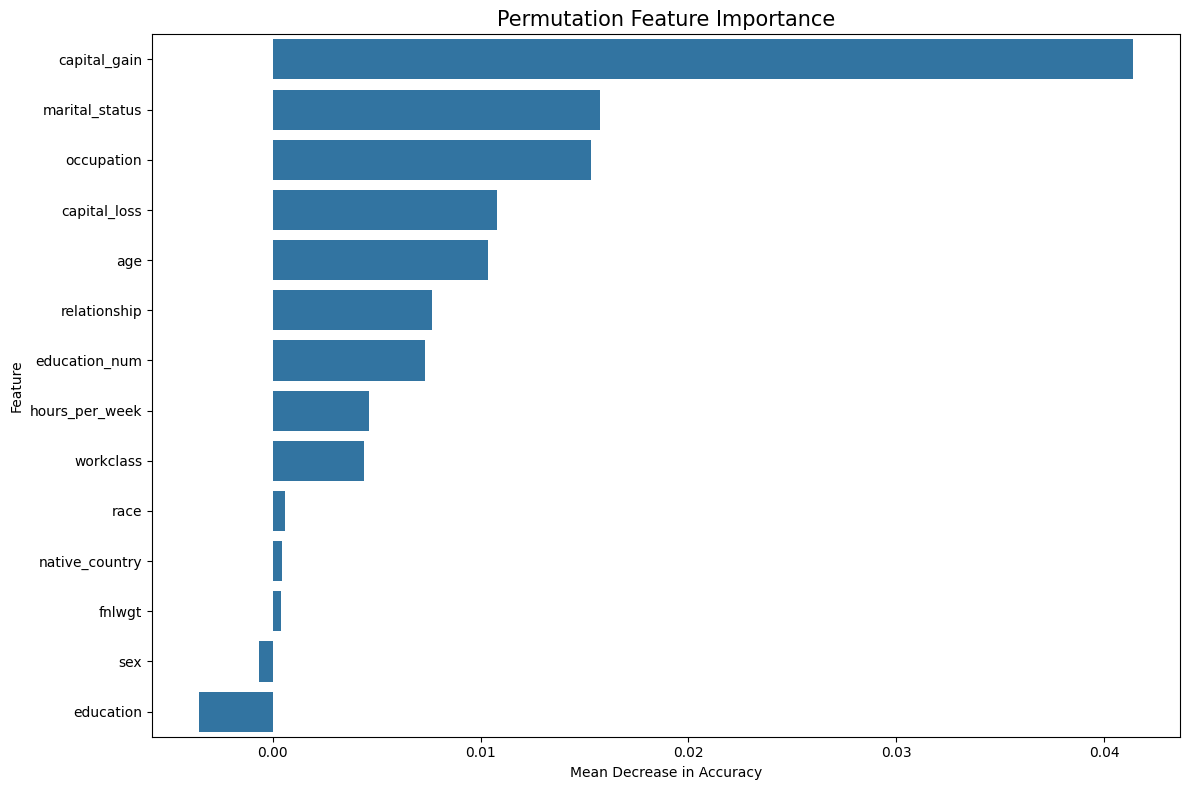


Top 10 features by permutation importance:
           Feature  Importance
10    capital_gain    0.041394
5   marital_status    0.015753
6       occupation    0.015292
11    capital_loss    0.010809
0              age    0.010379
7     relationship    0.007677
4    education_num    0.007308
12  hours_per_week    0.004637
1        workclass    0.004391
8             race    0.000614

Top 3 numerical features: ['capital_gain', 'capital_loss', 'age']


In [ ]:
print("\nCalculating permutation importance...")
try:
    # Calculate permutation importance
    result = permutation_importance(
        model, X_test, y_test,
        n_repeats=5,
        random_state=42,
        n_jobs=2
    )

    # Create DataFrame with original feature names
    perm_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean
    })

    # Sort and plot
    top_perm_features = perm_importance.sort_values('Importance', ascending=False).head(15)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_perm_features)
    plt.title('Permutation Feature Importance', fontsize=15)
    plt.xlabel('Mean Decrease in Accuracy')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 features by permutation importance:")
    print(top_perm_features.head(10))

    # Find top numerical features for PDPs
    top_num_features = perm_importance[perm_importance['Feature'].isin(numerical_cols)]
    top_num_features = top_num_features.sort_values('Importance', ascending=False)
    top_3_num_features = top_num_features.head(3)['Feature'].tolist()

except Exception as e:
    print(f"Error in permutation importance: {e}")
    # Fallback to using top numerical features from random forest
    num_importance = [(col, imp) for col, imp in zip(feature_names, importances)
                     if col in numerical_cols]
    num_importance.sort(key=lambda x: x[1], reverse=True)
    top_3_num_features = [x[0] for x in num_importance[:3]]

print(f"\nTop 3 numerical features: {top_3_num_features}")

#  Partial Dependence Plots**


Generating Partial Dependence Plots...


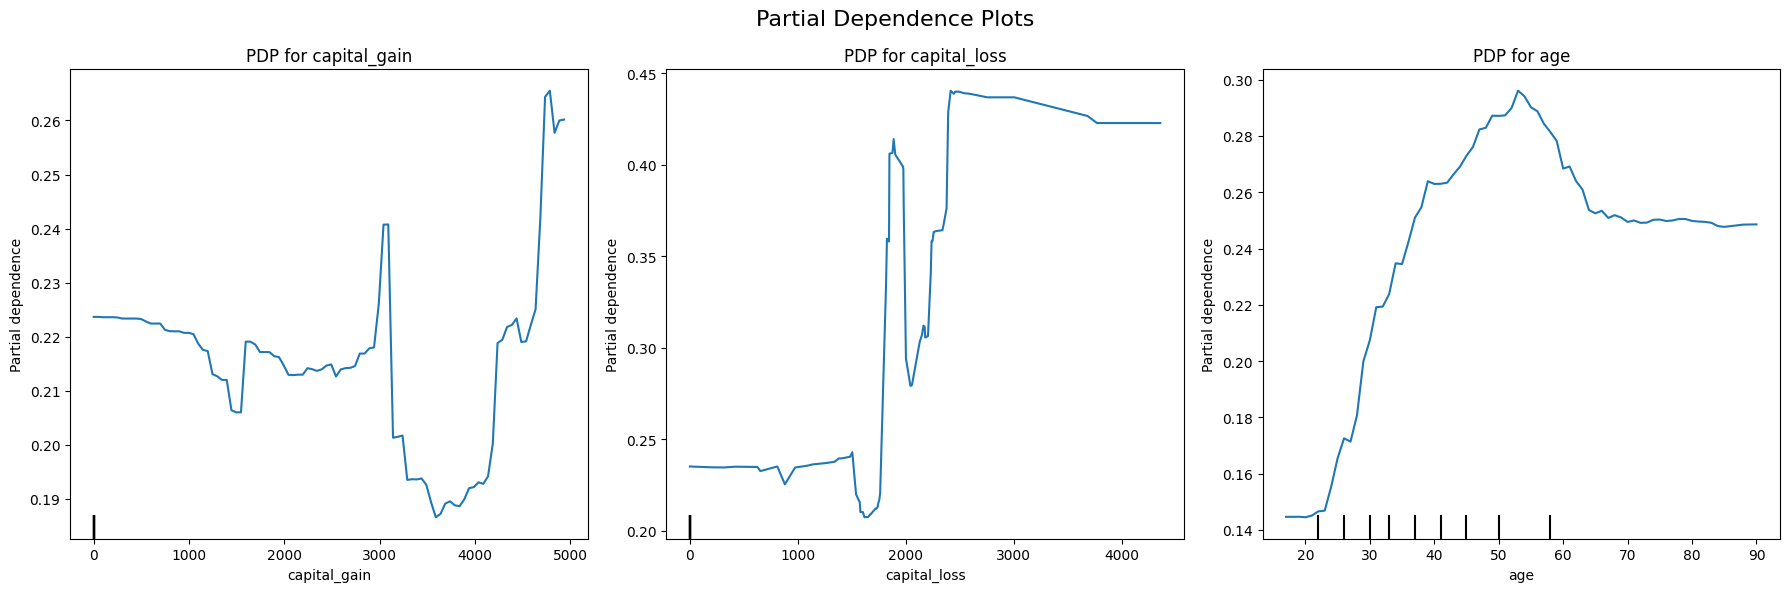

In [ ]:
print("\nGenerating Partial Dependence Plots...")
try:
    # Get indices of top numerical features
    feature_indices = [list(X.columns).index(feat) for feat in top_3_num_features]

    # Create PDPs
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    for i, feat_idx in enumerate(feature_indices):
        pd_plot = PartialDependenceDisplay.from_estimator(
            model,
            X_train,
            [feat_idx],
            ax=ax[i],
            kind="average",
            random_state=42
        )
        ax[i].set_title(f'PDP for {top_3_num_features[i]}')

    plt.suptitle('Partial Dependence Plots', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Generate 2D PDP for top 2 features
    if len(top_3_num_features) >= 2:
        fig, ax = plt.subplots(figsize=(10, 8))

        pd_plot = PartialDependenceDisplay.from_estimator(
            model,
            X_train,
            [(feature_indices[0], feature_indices[1])],
            ax=ax,
            kind="average",
            random_state=42
        )

        plt.suptitle(f'2D Partial Dependence: {top_3_num_features[0]} vs {top_3_num_features[1]}',
                    fontsize=14)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error generating PDPs: {e}")
    print("Generating individual PDPs instead...")

    # Try individual PDPs as fallback
    for feat in top_3_num_features:
        try:
            feat_idx = list(X.columns).index(feat)
            fig, ax = plt.subplots(figsize=(8, 6))

            pd_plot = PartialDependenceDisplay.from_estimator(
                model,
                X_train,
                [feat_idx],
                ax=ax,
                kind="average",
                random_state=42
            )

            plt.title(f'Partial Dependence Plot for {feat}')
            plt.tight_layout()
            plt.show()
        except Exception as inner_e:
            print(f"Could not generate PDP for {feat}: {inner_e}")


---

#  - **SHAP values** provided us with deep insights into which features were most influential for each prediction.
- **Summary plots** helped identify globally important features across the dataset.
- **Dependence plots** highlighted interactions between features.

> By using XAI tools like SHAP, we moved beyond model accuracy metrics and gained **trust** and **transparency** in our model's decision-making processes.
In real-world applications, this step is crucial for ensuring ethical, fair, and reliable AI systems.
